# Investigating the mean-variance relationship

### Imports

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp

In [42]:
import sys
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/simplesc')
import simplesc

### Simulation function


In [108]:
import math

def generalized_binom_coef(x,y):
    
#     if type(x) == int and type(y) == np.ndarray:
#         x = np.full_like(y, x)
#     if type(y) == int and type(y) == np.ndarray:
#         y = np.full_like(x, y)

    return sp.special.gamma(x+1) / (sp.special.gamma(y+1) * sp.special.gamma(x-y+1))

class toy_rv(stats.rv_discrete):
    
    def _pmf(self, k, n, p):
        
        return generalized_binom_coef(n, k) * p ** (k) * (1-p)**(n-k)
        

In [154]:
def simulate_data(mean, cov, p, num_cells, group_name, num_genes=2):
    
    norm_continuous = stats.multivariate_normal.rvs(mean=mean, cov=cov, size=num_cells)
    continuous = np.exp(norm_continuous)
    observed = toy_rv().rvs(n=continuous, p=p)
    
    adata = sc.AnnData(observed)
    #adata = sc.AnnData(sp.sparse.csr_matrix(observed))
    adata.obs['group'] = group_name
    adata.var.index = ['gene_1', 'gene_2']
    adata.obs.index = ['cell_' + str(i) for i in range(num_cells)]
    
    return adata, continuous

### Model fitting function

In [155]:
def fit_model(adata, p, group_1='g1', group_2='g2', num_permute=5):
    
    estimator = simplesc.SingleCellEstimator(
        adata, 
        p=p, 
        num_permute=num_permute,
        group_label='group')
    
    estimator.compute_observed_statistics(group=group_1)
    #estimator.compute_observed_statistics(group=group_2)
        
    estimator.compute_params(group=group_1)
    #estimator.compute_params(group=group_2)

    estimator.compute_permuted_statistics(group=group_1)
    #estimator.compute_permuted_statistics(group=group_2)
    
    return estimator

### Mean variance dependence

In [157]:
# Parameters for FPR simulation
num_cells = 5000
p = 0.1
p_hat = 0.1

mu_1 = np.array([1, 1])
cov_1 = np.array([[0.1, 0], [0, 2]])

In [163]:
mean, var = [], []
gt_mean, gt_var = [], []
for trial in range(50):

    adata, gt_counts = \
        simulate_data(mu_1, cov_1, p, num_cells, 'g1')

    estimator = fit_model(adata, p_hat, num_permute=1)

    mean.append(estimator.estimated_mean['g1'][0])
    var.append(estimator.estimated_cov['g1'][0, 0])
    
    gt_mean.append(np.log(gt_counts[:, 0][gt_counts[:, 0] > 0]).mean())
    gt_var.append(np.log(gt_counts[:, 0][gt_counts[:, 0] > 0]).var())
    
    
    

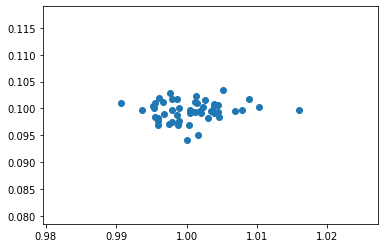

In [164]:
plt.scatter(gt_mean, gt_var)

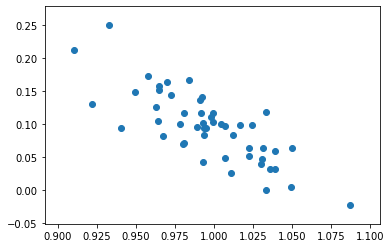

In [165]:
plt.scatter(mean, var)

In [197]:
mu_list = []
var_list = []


for mu in np.arange(0, 3, 0.01):
    
    mu_1 = [mu, 1]
    #cov_1 = [[mu, 0], [0, 1]]
    
    adata = \
        simulate_data(mu_1, cov_1, p, num_cells, 'g1')
    
    estimator = fit_model(adata, num_permute=1, p=p)
    
    mu_list.append(estimator.estimated_mean['g1'][0])
    var_list.append(estimator.estimated_cov['g1'][0,0])

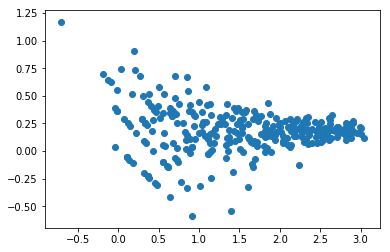

In [198]:
plt.scatter(mu_list, var_list)